In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils import plotFigureGray, plotFigure
from student_code import harris_corners, get_keypoints

(-0.5, 1523.5, 2031.5, -0.5)

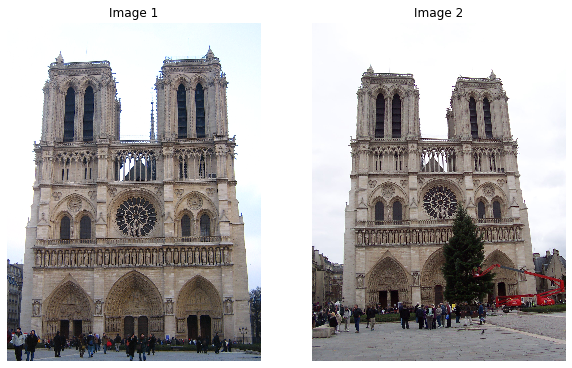

In [2]:
img1 = cv2.imread('../data/notre_dame1.jpg')
img2 = cv2.imread('../data/notre_dame2.jpg')



gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray1 = np.float32(gray1)

gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
gray2 = np.float32(gray2)


fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1[:,:,::-1])#,cmap='gray')
plt.title("Image 1")
plt.axis('off')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2[:,:,::-1])#,cmap='gray')
plt.title("Image 2")
plt.axis('off')
#plt.show()


(-0.5, 1535.5, 2047.5, -0.5)

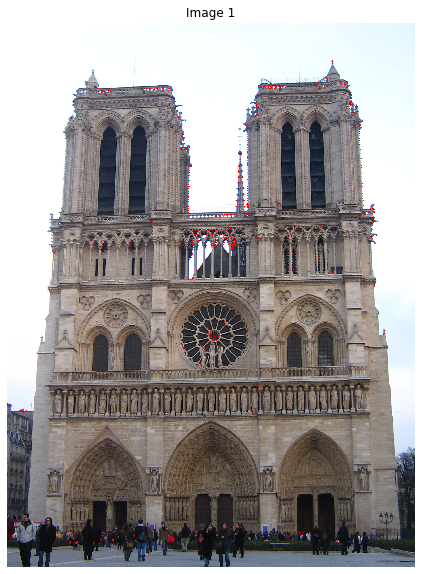

In [10]:
img_harris = img1.copy()
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#gray = np.float32(gray)
dst = cv2.cornerHarris(img1_gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img_harris[dst>0.06*dst.max()]=[0,0,255]
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img_harris[:,:,::-1])
plt.title("Image 1")
plt.axis('off')

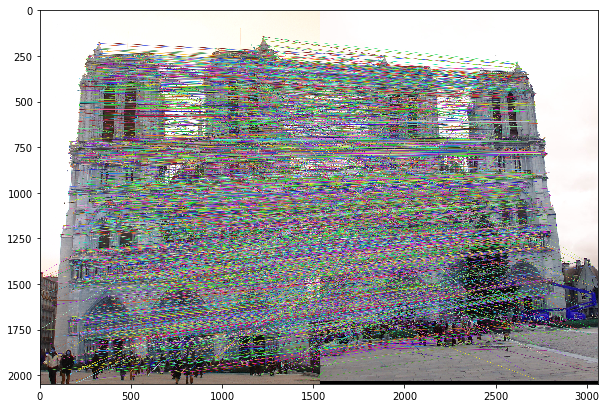

(<matplotlib.image.AxesImage at 0x7f9f98089f70>, None)

In [13]:
#img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
#img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.85*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,1,1)
# ax1.imshow(img_harris[:,:,::-1])
# plt.title("Image 1")
# plt.axis('off')
plt.imshow(img3),plt.show()

In [ ]:
def harris_corners(image, window_size=5, alpha=0.04, threshold=1e-2, nms_size=10):
    ### YOUR CODE HERE
    img1_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img1_gray_blur = cv2.GaussianBlur(img1_gray,(5,5),0)
    #img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    Ix_ = cv2.Sobel(img1_gray_blur,cv2.CV_8U,1,0,ksize=3)
    Iy_ = cv2.Sobel(img1_gray_blur,cv2.CV_8U,0,1,ksize=3)  
    Ixy_ = Ix_*Iy_ #cv2.Sobel(img1_gray_blur,cv2.CV_64F,1,1,ksize=3) 
    Ix = cv2.GaussianBlur(Ix_,(5,5),cv2.BORDER_DEFAULT) 
    Ix2 = Ix * Ix
    Iy = cv2.GaussianBlur(Iy_,(5,5),cv2.BORDER_DEFAULT) 
    Iy2 = Iy * Iy
    Ixy = cv2.GaussianBlur(Ixy_,(5,5),cv2.BORDER_DEFAULT) 
    height = image.shape[0]
    width = image.shape[1]
    window_size = 5
    corners = np.array([])
    image2 = image.copy()
    color_img = image2#cv2.cvtColor(image2,cv2.COLOR_GRAY2RGB)
    padding = int(window_size/2)
    threshold = 10**8
    alpha = 0.04
    max = 0
    total_r = 0
    count_r = 0
    wc = 0 # wild card
    Response_mat = np.full((height,width), 0,  dtype=np.float)
    for y in range(padding,height-padding):
      for x in range(padding,width-padding):
        windowIx2 = Ix2[y-padding:y+padding+1, x-padding:x+padding+1]
        windowIxy = Ixy[y-padding:y+padding+1, x-padding:x+padding+1]
        windowIy2 = Iy2[y-padding:y+padding+1, x-padding:x+padding+1]
        Sx2 = windowIx2.sum()
        Sxy = windowIxy.sum()
        Sy2 = windowIy2.sum()
        # response function
        det = (Sx2 * Sy2) - (Sxy ** 2)
        trace = Sx2 + Sy2
        r = det - alpha*(trace**2)
        if r>max:
            max=r
        total_r += r
        count_r += 1
        try:
            Response_mat[x][y] = r
        except:
            wc +=1
        #color if greater than threshold
        if r>threshold:
          corners.append([x,y,r])
          color_img.itemset((y, x, 0), 0)
          color_img.itemset((y, x, 1), 0)
          color_img.itemset((y, x, 2), 255)
    print("corners : ",corners)
    return corners, Ix_, Iy_